In [85]:
import frame
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

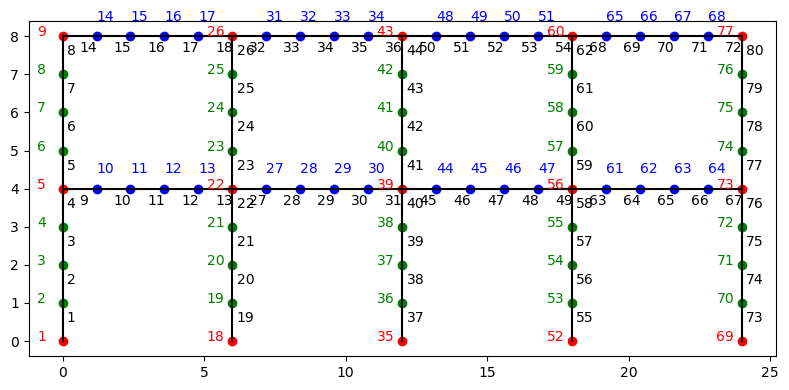

In [86]:
n_bays = 4
n_floors = 2
a_frame = frame.frame(num_bays = n_bays, num_floors = n_floors, 
                bay_length = 6, floor_height = 4, 
                elements_per_bay = 5, elements_per_floor = 4)
a_frame.plot_mesh()

In [87]:
def create_node_dual_graph(nodes, elements):
    G = nx.Graph()
    
    # Add nodes to the graph
    for node in nodes:
        G.add_node(node.id, pos=(node.x, node.y))
    
    # Add edges based on element connectivity
    for element in elements:
        if element.id <= 26:
            G.add_edge(element.nodes_ids[0], element.nodes_ids[1], weight=0.3)
        else:
            G.add_edge(element.nodes_ids[0], element.nodes_ids[1], weight=0.3)
    
    return G

def plot_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')

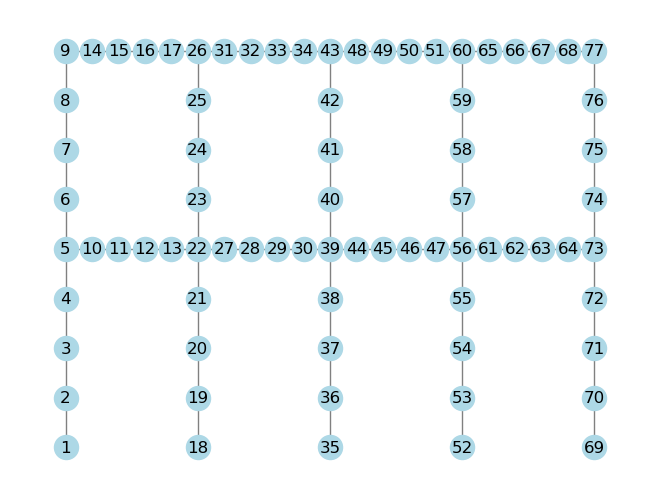

In [88]:
dual_graph = create_node_dual_graph(a_frame.nodes, a_frame.elements)
plot_graph(dual_graph)

In [89]:
def color_graph(G):
    # Use the greedy coloring algorithm to color the graph
    coloring = nx.coloring.greedy_color(G, strategy="largest_first")
    return coloring

def plot_colored_graph(G, coloring):
    pos = nx.get_node_attributes(G, 'pos')
    colors = plt.cm.rainbow(np.linspace(0, 1, max(coloring.values()) + 1))
    
    for node, color in coloring.items():
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=[colors[color]], node_size=300)
    
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos)
    plt.show()

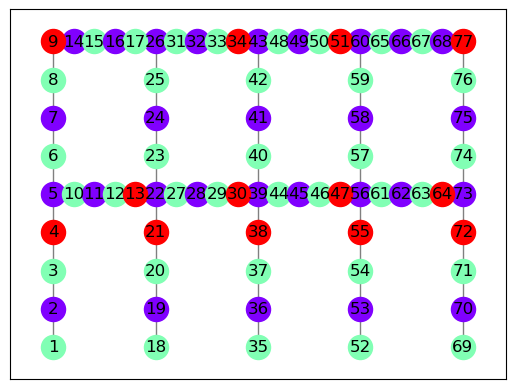

In [90]:
coloring = nx.coloring.greedy_color(dual_graph)
plot_colored_graph(dual_graph, coloring)

In [91]:
def spectral_partitioning(G):
    # Compute the Laplacian matrix of the graph
    L = nx.laplacian_matrix(G, weight="weight").astype(float)
    
    # Compute the first k eigenvectors of the Laplacian matrix
    _, eigvecs = eigsh(L, k=2, which='SM')
    
    # Use the eigenvectors to partition the graph
    # Here we use k-means clustering on the eigenvectors
    return (np.sign(eigvecs).astype(int)[:,1] + 1)//2
    


In [92]:
partition_labels = spectral_partitioning(dual_graph)

In [93]:
nodal_list = np.array(list(dual_graph.nodes))
print(f"nodal list = {nodal_list}")
print(f"true nodal list = {nodal_list[partition_labels.astype(bool)]}")
print(f"false nodal list = {nodal_list[~partition_labels.astype(bool)]}")

nodal list = [10 11 12 13 27 28 29 30 44 45 46 47 61 62 63 64 14 15 16 17 31 32 33 34
 48 49 50 51 65 66 67 68  1  2  3  4  5  6  7  8  9 18 19 20 21 22 23 24
 25 26 35 36 37 38 39 40 41 42 43 52 53 54 55 56 57 58 59 60 69 70 71 72
 73 74 75 76 77]
true nodal list = [10 11 12 13 27 28 29 30 14 15 16 17 31 32 33 34  1  2  3  4  5  6  7  8
  9 18 19 20 21 22 23 24 25 26]
false nodal list = [44 45 46 47 61 62 63 64 48 49 50 51 65 66 67 68 35 36 37 38 39 40 41 42
 43 52 53 54 55 56 57 58 59 60 69 70 71 72 73 74 75 76 77]


In [94]:
def plot_partitioned_graph(G, partition_labels):
    pos = nx.get_node_attributes(G, 'pos')
    colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(partition_labels))))
    nodal_list = np.array(list(dual_graph.nodes))
    
    nx.draw_networkx_nodes(G, pos, nodelist=nodal_list[partition_labels.astype(bool)], node_color=[colors[0]], node_size=300)
    nx.draw_networkx_nodes(G, pos, nodelist=nodal_list[~partition_labels.astype(bool)], node_color=[colors[1]], node_size=300)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos)
        

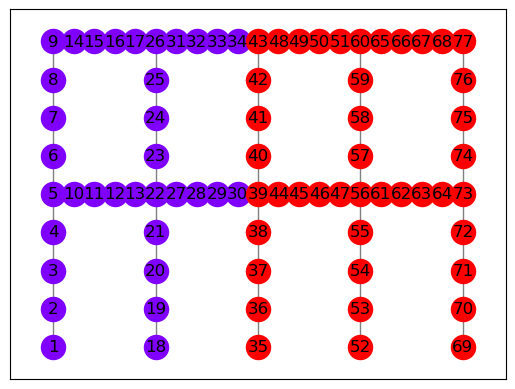

In [95]:
plot_partitioned_graph(dual_graph, partition_labels)

In [96]:
# kernighan_lin_bisection(G, partition=None, max_iter=10, weight='weight', seed=None)[source]
# parted_graph = nx.community.kernighan_lin_bisection(dual_graph, max_iter=1, seed=666)
# plot_partitioned_graph(dual_graph, parted_graph)
# print(parted_graph)